In [1]:
# Install required libraries
# !pip install transformers torch pandas scikit-learn

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


In [2]:
# Load the dataset
df = pd.read_csv('./finalDataset.csv')
df



,text,span,label,ordinal
0,positive point 1 camera quality is good but n...,battery,positive,0
1,after using 3 days here is my concern regardin...,battery,positive,0
2,all things is good in this phone camera qualit...,battery,positive,0
3,phone is awesome and camera quality is super a...,battery,positive,0
4,all good but battery performance is not so goo...,design,positive,0
...,...,...,...,...
779,i am disappointed with the display quality it ...,display,negative,3
780,superb phone best phone under 25k camera 55 wa...,camera,positive,3
781,i am disappointed with the display quality it ...,display,negative,3
782,everything thing on this device is very good c...,battery,positive,4


In [4]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, keeping apostrophes for contractions
    text = re.sub(r'[^a-zA-Z\'\s]', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Custom list of stopwords, excluding negations and other sentiment-bearing words
    custom_stop_words = set([
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'
    ])

    # List of negations and sentiment-bearing words to keep
    important_words = set([
        'not', 'no', 'never', 'none', 'nobody', 'nowhere', 'neither', 'nor',
        'doesn\'t', 'isn\'t', 'wasn\'t', 'shouldn\'t', 'wouldn\'t', 'couldn\'t', 'won\'t',
        'can\'t', 'don\'t'
    ])
    stop_words = set(stopwords.words('english'))

    # Remove custom stopwords but keep important words
    tokens = [token for token in tokens if token not in stop_words or token in important_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\heyfa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\heyfa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\heyfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Apply preprocessing to the 'text' column
df['text']=df['text'].apply(preprocess_text)
df

,text,span,label,ordinal
0,positive point camera quality good not enough ...,battery,positive,0
1,using day concern regarding phone pro excellen...,battery,positive,0
2,thing good phone camera quality display batter...,battery,positive,0
3,phone awesome camera quality super awesome eve...,battery,positive,0
4,good battery performance not goodlooks good pe...,design,positive,0
...,...,...,...,...
779,disappointed display quality offer low brightn...,display,negative,3
780,superb phone best phone k camera warms little ...,camera,positive,3
781,disappointed display quality offer low brightn...,display,negative,3
782,everything thing device good camera awesome ma...,battery,positive,4


In [6]:
# Encode labels and aspects
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
aspect_encoder = LabelEncoder()
df['span_encoded'] = aspect_encoder.fit_transform(df['span'])

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [7]:
# Define the dataset class
class AspectSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        aspect = self.data.iloc[index]['span']
        inputs = self.tokenizer.encode_plus(
            aspect,
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'labels': torch.tensor(self.data.iloc[index]['label_encoded'], dtype=torch.long)
        }


In [8]:

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)



In [9]:
# Prepare datasets and dataloaders
train_dataset = AspectSentimentDataset(train_df, tokenizer, max_len=128)
val_dataset = AspectSentimentDataset(val_df, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



In [9]:
# Training settings
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# optimizer = AdamW(model.parameters(), lr=2e-5)
# num_epochs = 3


In [10]:
from tqdm import tqdm

In [11]:

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
#     for batch in train_loader:
#         optimizer.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         token_type_ids = batch['token_type_ids'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         train_pbar.set_postfix({'loss': train_loss / (train_pbar.n + 1)})

#     # Validation
#     model.eval()
#     val_loss = 0
#     correct = 0
#     total = 0
#     val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             token_type_ids = batch['token_type_ids'].to(device)
#             labels = batch['labels'].to(device)
#             outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
#             val_loss += outputs.loss.item()
#             _, predicted = torch.max(outputs.logits, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             val_pbar.set_postfix({'loss': val_loss / (val_pbar.n + 1), 'accuracy': 100 * correct / total})

#     print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {100 * correct / total:.2f}%')



In [12]:
# Save the model
# torch.save(model.state_dict(), 'aspect_sentiment_model.pth')

In [10]:
def load_saved_model(model_path):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.to('cpu')
    model.eval()
    return model

In [11]:
loaded_model = load_saved_model('./10/aspect_sentiment_model.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import re

def predict_sentiments(text, model, tokenizer, label_encoder, device):
    aspects = ['battery', 'display', 'design', 'performance', 'camera']
    results = {}

    model.eval()

    for aspect in aspects:
        # Check if the aspect is mentioned in the text
        aspect_pattern = r'\b' + re.escape(aspect) + r'\b'
        if re.search(aspect_pattern, text, re.IGNORECASE):
            # Find the sentence containing the aspect
            sentences = re.split(r'(?<=[.!?])\s+', text)
            relevant_sentence = next((s for s in sentences if re.search(aspect_pattern, s, re.IGNORECASE)), text)

            # Prepare input for the model
            inputs = tokenizer.encode_plus(
                aspect,
                relevant_sentence,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                return_tensors='pt'
            )

            # Make prediction
            with torch.no_grad():
                outputs = model(
                    inputs['input_ids'].to(device),
                    attention_mask=inputs['attention_mask'].to(device),
                    token_type_ids=inputs['token_type_ids'].to(device)
                )

            _, predicted = torch.max(outputs.logits, 1)
            sentiment = label_encoder.inverse_transform([predicted.item()])[0]

            results[aspect] = sentiment

    return results

In [13]:
text = "battery doesn't last long"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [17]:
text = "battery short life"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [18]:
text = "design is very old"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: design, Sentiment: negative


In [19]:
text = "design is latest technology"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: design, Sentiment: positive


In [20]:
text = "battery is drains very fast with short battery life"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [21]:
text = "picture from rear camera is crystal clear"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: camera, Sentiment: positive


In [22]:
text = "picture from rear camera is blur"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: camera, Sentiment: negative


In [23]:
text = "it becomes too too too hot ,iam so disappointed with this brand . there is no difference between 4g and 5g . battery was weak iam charging twice a day,for basic level of usage itself."

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [24]:
text = "having big one major problem it's very fast battery draining"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [14]:
text = '''Realme p1 5g is the one of the best smart phone under 15k.. camera it's ok
Battery 🔋 maximum 1days
Display is amoled so nice 👍
Design very nice
Performance.. mediatek 7050 is very powerful.. free fire 60fps....and...Bgmi.. smooth extreme..💪💪.. I Love 💗 this phone..'''

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: positive
Aspect: display, Sentiment: positive
Aspect: design, Sentiment: positive
Aspect: performance, Sentiment: positive
Aspect: camera, Sentiment: positive


In [26]:
text = ""

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

In [27]:
text = '''
But battery backup very poor
Atleast one day not stand by battery backup
Very fast drain the battery
Worst battery
Not go to buy this phone'''

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [15]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

def split_text(text):
    # First, split by newline characters
    split_by_newlines = text.split('\n')
    all_sentences = []
    
    for part in split_by_newlines:
        if part.strip():  # Ignore empty parts
            all_sentences.extend(split_on_conjunctions(part))
    
    return all_sentences

def split_on_conjunctions(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []
    
    for token in doc:
        current_sentence.append(token.text)
        
        # If we encounter a coordinating conjunction or new sentence, split
        if token.dep_ == 'cc' or token.text == '.':
            sentences.append(' '.join(current_sentence).strip())
            current_sentence = []
    
    # Add the final sentence if any
    if current_sentence:
        sentences.append(' '.join(current_sentence).strip())
    
    return sentences

# Test case
text = '''Design - Awesome Looking and Dimensity 7050 5G Processor - Good  Amoled Display - Decent
Sound Experience is also Good but Camera Quality is superb'''

sentences = split_text(text)

# Output each split sentence
for idx, sentence in enumerate(sentences):
    print(f"Sentence {idx+1}: {sentence}")


Sentence 1: Design - Awesome Looking and
Sentence 2: Dimensity 7050 5 G Processor - Good   Amoled Display - Decent
Sentence 3: Sound Experience is also Good but
Sentence 4: Camera Quality is superb


In [33]:
def predict_sentences(text):
    # text = preprocess_text(text)
    
    sentences = split_text(text)
    
    for text in sentences :
        
        print(text)

        predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

        for aspect, sentiment in predictions.items():
            print(f"Aspect: {aspect}, Sentiment: {sentiment}")
            print()

In [17]:
text = '''Design - Awesome Looking
Dimensity 7050 5G Processor - Good
Amoled Display - Decent
Sound Experience is also Good
Camera Quality - superB
Smoothly Running All Apps.'''
predict_sentences(text)

Design - Awesome Looking
Aspect: design, Sentiment: positive

Dimensity 7050 5 G Processor - Good
Amoled Display - Decent
Aspect: display, Sentiment: positive

Sound Experience is also Good
Camera Quality - superB
Aspect: camera, Sentiment: positive

Smoothly Running All Apps .


In [30]:
text = '''it becomes too too too hot ,iam so disappointed with this brand . there is no difference between 4g and 5g . battery was weak iam charging twice a day,for basic level of usage itself.'''
predict_sentences(text)

becomes hot iam disappointed brand no difference g g battery weak iam charging twice day basic level usage
Aspect: battery, Sentiment: negative



In [34]:
text = '''SERIOUSLY IT'S TOO GOOD.
GAME IS SMOOTH IN BGMI BASIS NO.NO.NO..IT'S OVER SMOOTH.
YOU FEEL ALWAYS COOL YOUR PHONE..CAMERA QUALITY..OHO..OHO.OHO..NICE'''
predict_sentences(text)

SERIOUSLY IT 'S TOO GOOD .
GAME IS SMOOTH IN BGMI BASIS NO.NO.NO .. IT 'S OVER SMOOTH .
YOU FEEL ALWAYS COOL YOUR PHONE .. CAMERA QUALITY .. OHO .. OHO.OHO .. NICE
Aspect: camera, Sentiment: negative



In [35]:
text = '''Nice phone this price range
Camera quality is not that good
Very bad display
Battery back is good'''
predict_sentences(text)

Nice phone this price range
Camera quality is not that good
Aspect: camera, Sentiment: negative

Very bad display
Aspect: display, Sentiment: negative

Battery back is good
Aspect: battery, Sentiment: positive



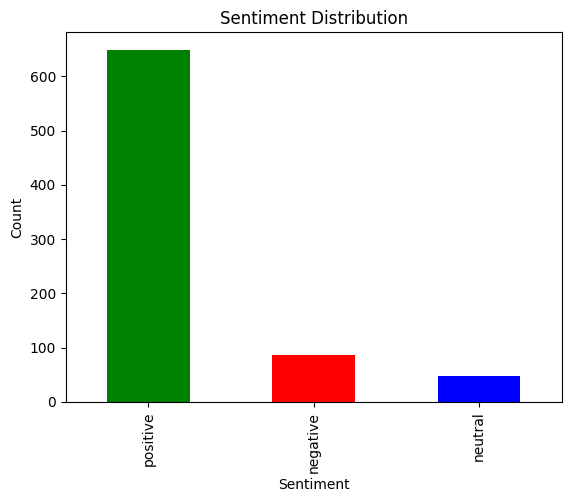

In [34]:
import matplotlib.pyplot as plt

# Plot sentiment distribution
df['label'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

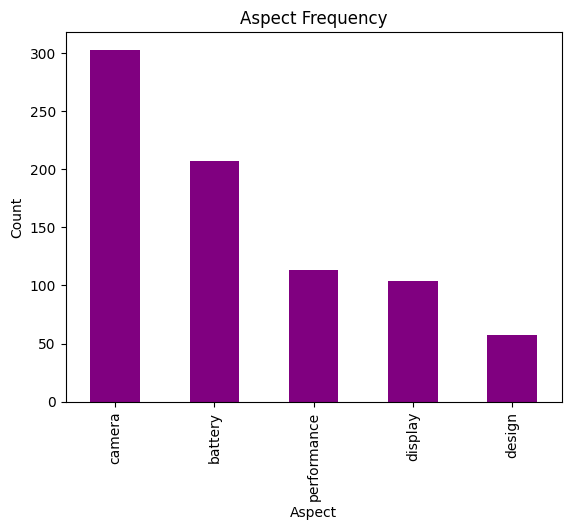

In [35]:
# Plot aspect distribution
df['span'].value_counts().plot(kind='bar', color='purple')
plt.title('Aspect Frequency')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.show()

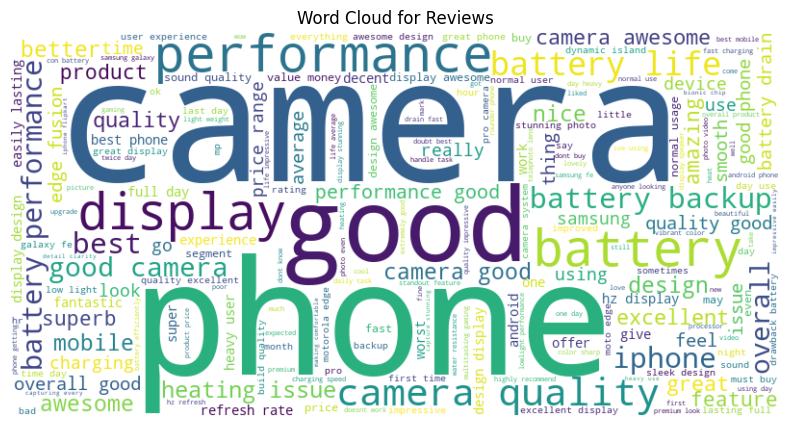

In [36]:
# !pip install wordcloud
from wordcloud import WordCloud

# Generate a word cloud for the reviews
reviews_text = " ".join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reviews')
plt.show()

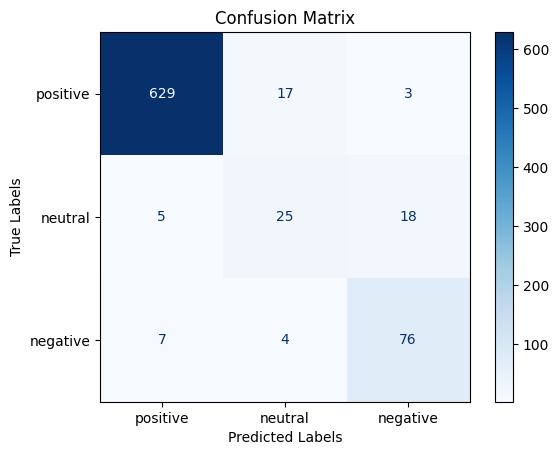

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure the true labels and predicted labels are properly aligned
y_true = df['label']  # Replace with the correct column name for true sentiment labels
y_pred = df['pred']   # Replace with the predicted sentiment column from your DataFrame

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


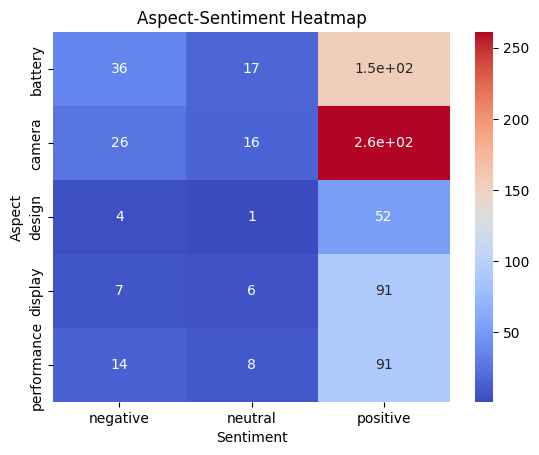

In [38]:
# !pip install seaborn
import seaborn as sns

# Create a pivot table for heatmap
heatmap_data = df.pivot_table(index='span', columns='label', aggfunc='size', fill_value=0)

# Plot the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Aspect-Sentiment Heatmap')
plt.xlabel('Sentiment')
plt.ylabel('Aspect')
plt.show()


In [39]:
# from tqdm import tqdm

# def predict_and_save_sentiments(df, split_text_func, predict_sentiments_func, model, tokenizer, label_encoder, device):
#     """
#     Predict sentiments for each review's specified aspect and save the results.
    
#     Args:
#         df (pd.DataFrame): The DataFrame containing 'text', 'span', and 'label'.
#         split_text_func (function): Function to split review text into sentences.
#         predict_sentiments_func (function): Function to predict sentiments for a single sentence.
#         model: The trained sentiment analysis model.
#         tokenizer: Tokenizer for the model.
#         label_encoder: Label encoder to map predictions back to sentiment labels.
#         device: Device to run the model (e.g., 'cpu' or 'cuda').
    
#     Returns:
#         pd.DataFrame: DataFrame with an additional column 'pred' for predictions.
#     """
#     predictions = []

#     # Using tqdm to track progress
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Predicting Sentiments"):
#         review_text = row['text']
#         target_aspect = row['span']

#         # Split review text into sentences
#         sentences = split_text_func(review_text)

#         # Aggregate predictions for the aspect
#         predicted_sentiment = None
#         for sentence in sentences:
#             # Predict aspects and sentiments for each sentence
#             aspect_predictions = predict_sentiments_func(sentence, model, tokenizer, label_encoder, device)

#             # Check if the target aspect matches any predicted aspect
#             if target_aspect in aspect_predictions:
#                 predicted_sentiment = aspect_predictions[target_aspect]
#                 break  # Take the first matching aspect's sentiment

#         # Append the predicted sentiment
#         predictions.append(predicted_sentiment)

#     # Add the predictions to the DataFrame
#     df['pred'] = predictions
#     return df


In [40]:
# from tqdm import tqdm

# # Apply the function with tqdm
# df = predict_and_save_sentiments(
#     df,
#     split_text_func=split_text,
#     predict_sentiments_func=predict_sentiments,
#     model=loaded_model,
#     tokenizer=tokenizer,
#     label_encoder=label_encoder,
#     device='cpu'
# )

# # Save the DataFrame to a file
# df.to_csv('predicted_dataset.csv', index=False)

# print("Predictions saved to 'predicted_dataset.csv'")


Predicting Sentiments:   8%|████▋                                                     | 64/784 [00:48<08:52,  1.35it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tok

Predictions saved to 'predicted_dataset.csv'


In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['positive', 'neutral', 'negative']))


              precision    recall  f1-score   support

    positive       0.78      0.87      0.83        87
     neutral       0.54      0.52      0.53        48
    negative       0.98      0.97      0.98       649

    accuracy                           0.93       784
   macro avg       0.77      0.79      0.78       784
weighted avg       0.93      0.93      0.93       784



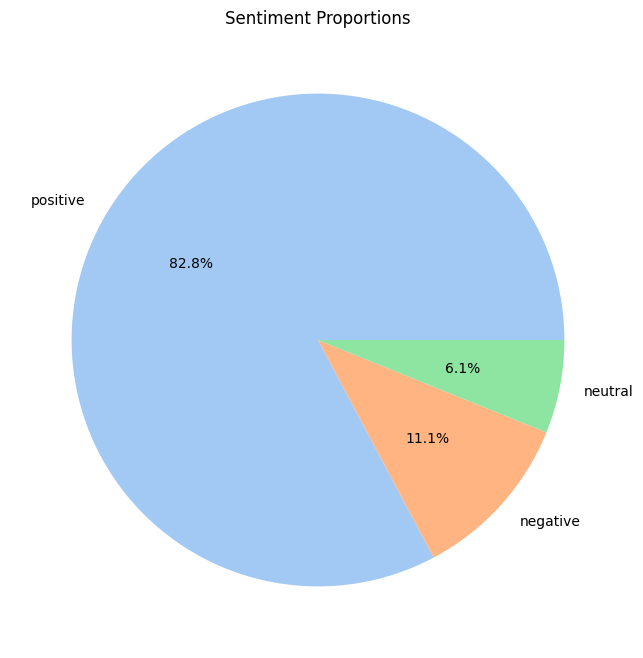

In [48]:
# Sentiment proportions
sentiment_proportions = df['label'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
plt.pie(sentiment_proportions.values, labels=sentiment_proportions.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Sentiment Proportions')
plt.show()


C:\Users\heyfa\AppData\Local\Temp\ipykernel_2752\3676750627.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aspect_accuracy = df.groupby('span').apply(lambda x: (x['label'] == x['pred']).mean())


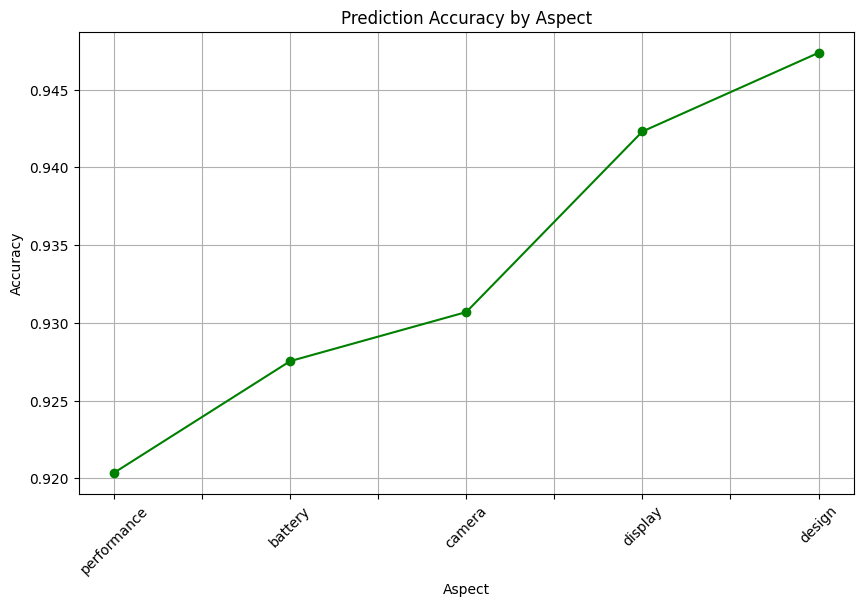

In [50]:
aspect_accuracy = df.groupby('span').apply(lambda x: (x['label'] == x['pred']).mean())

plt.figure(figsize=(10, 6))
aspect_accuracy.sort_values().plot(kind='line', marker='o', color='green')
plt.title('Prediction Accuracy by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [18]:
text = '''battery is not that good but camera is decent'''
predict_sentences(text)

battery is not that good but
Aspect: battery, Sentiment: negative

camera is decent
Aspect: camera, Sentiment: positive



In [52]:
text = '''camera quality is not that good battery is good'''
predict_sentences(text)

camera quality is not that good battery is good
Aspect: battery, Sentiment: negative

Aspect: camera, Sentiment: negative



In [56]:
text = '''battery, camera, display, performance are good but design is very pathetic'''
predict_sentences(text)

battery , camera , display , performance are good but
Aspect: battery, Sentiment: positive

Aspect: display, Sentiment: positive

Aspect: performance, Sentiment: positive

Aspect: camera, Sentiment: positive

design is very pathetic
Aspect: design, Sentiment: negative



In [60]:
text = '''camera'''
predict_sentences(text)

camera
Aspect: camera, Sentiment: neutral

